In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('/kaggle/input/customer-personality-analysis/marketing_campaign.csv',sep='\t')
pd.set_option('display.max_columns', None)
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [4]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [5]:
df.shape

(2240, 29)

In [6]:
df.dropna(inplace=True)

In [7]:
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'], dayfirst=True)

In [8]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

### To Do:-
***

#### EDA:-
    * Make Density Distribution of Age,Income,Recency,total amount spent
    * Make Bar charts for Education, Kidhome, Teenhome, Complaint, Purchses type,Offer accepted in campaing vs amount_spent
    * Box Plot for numerical columns to check outliers and remove them using IQR     
***
#### Feature Engg:-
    * Drop- ID,Year_Birth,Dt_Customer, Dt_Customer
    * Cal age from Year_Birth, duration from Dt_Customer
    * Make a column of total amount spent by consumer
    * Lets take year of Data to be 2021 for internal cal if needed
***
#### Clustering:-
    * Elbow and Silhottes Method to find K
    * K Means with K++ Initialization
    * Calculate Epsilon and Min Samples for DBSCAN
    * Impliment DBSCAN
    * Do the above after PCA:- Find loss of information when using PCA
***

In [9]:
print(f"Value counts in {df['Z_CostContact'].value_counts()},\nand in {df['Z_Revenue'].value_counts()}")
# We can drop these columns as they are totally same

Value counts in Z_CostContact
3    2216
Name: count, dtype: int64,
and in Z_Revenue
11    2216
Name: count, dtype: int64


In [10]:
# Taking Present year as 2021 as the data was published 3 years ago from 2024

df['Age']=2021-df['Year_Birth']
df['Duration']=pd.to_datetime('31-12-2021', dayfirst=True)-df['Dt_Customer']

In [11]:
df.drop(columns=['Year_Birth','Dt_Customer','ID','Z_CostContact','Z_Revenue'],axis=1, inplace=True)
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Duration
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,64,3405 days
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,67,2855 days
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,56,3054 days
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,37,2881 days
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,40,2903 days


In [12]:
df['Mnt_Tot']=df['MntWines']+df['MntFruits']+df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']+df['MntGoldProds']

### Data In Depth Analysis

In [13]:
# Outliers Detection
# Box Plot
# IQR
# K-Means, Isolation forest, DBSCAN

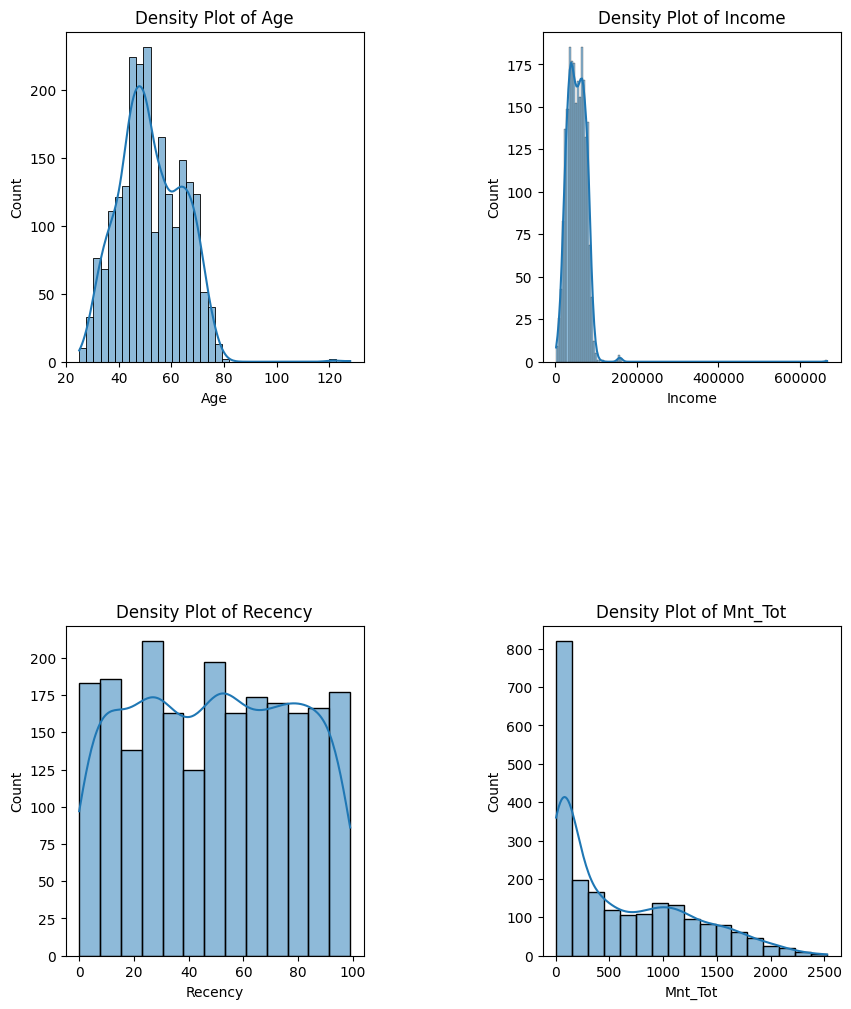

In [14]:
fig, axes=plt.subplots(nrows=2, ncols=2, figsize=(10,12))
axes=axes.flatten()

used_axes = 0
for ind,col in enumerate(['Age','Income','Recency','Mnt_Tot']):
    sns.histplot(data=df,x=col,ax=axes[used_axes],kde=True)
    axes[used_axes].set_title(f'Density Plot of {col}')
    used_axes+=1

for ax in axes[used_axes:]:
    fig.delaxes(ax)
    
plt.subplots_adjust(hspace=0.8,wspace=0.6)
plt.show()

In [15]:
df.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Age', 'Duration', 'Mnt_Tot'],
      dtype='object')

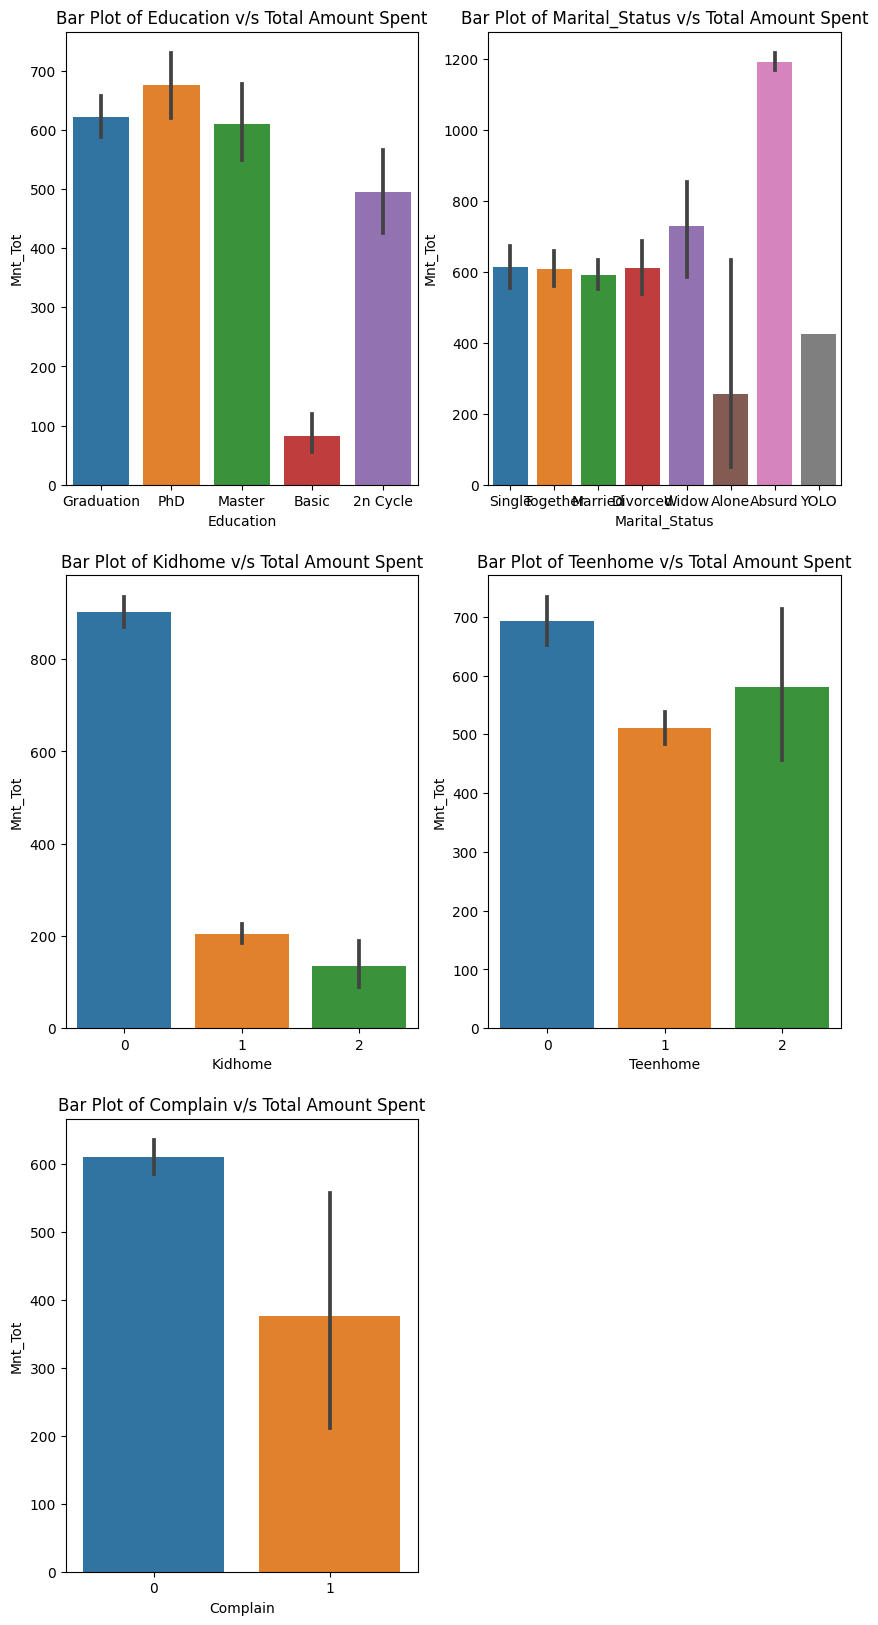

In [16]:
fig, axes=plt.subplots(nrows=3, ncols=2, figsize=(10,20))
axes=axes.flatten()

used_axes = 0
bar_lst = ['Education','Marital_Status', 'Kidhome', 'Teenhome', 'Complain']

for ind,col in enumerate(bar_lst):
    sns.barplot(data=df,x=col,y='Mnt_Tot' ,ax=axes[used_axes])
    axes[used_axes].set_title(f'Bar Plot of {col} v/s Total Amount Spent')
    used_axes+=1

for ax in axes[used_axes:]:
    fig.delaxes(ax)
    
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

In [17]:
# To be encoded
cat_col = ['Education','Marital_Status','Kidhome','Teenhome']

# To be scaled and treated for outliers
num_col = ['Income','Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts',
           'MntGoldProds','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases',
           'NumWebVisitsMonth','Age','Duration','Mnt_Tot']

In [18]:
df['Duration'] = df['Duration'].apply(lambda x: x.days)
df['Duration'].astype('int64')

0       3405
1       2855
2       3054
3       2881
4       2903
        ... 
2235    3123
2236    2761
2237    2897
2238    2898
2239    3364
Name: Duration, Length: 2216, dtype: int64

### Outliers Treatment:- IQR Method

#### Box Plot Visualization

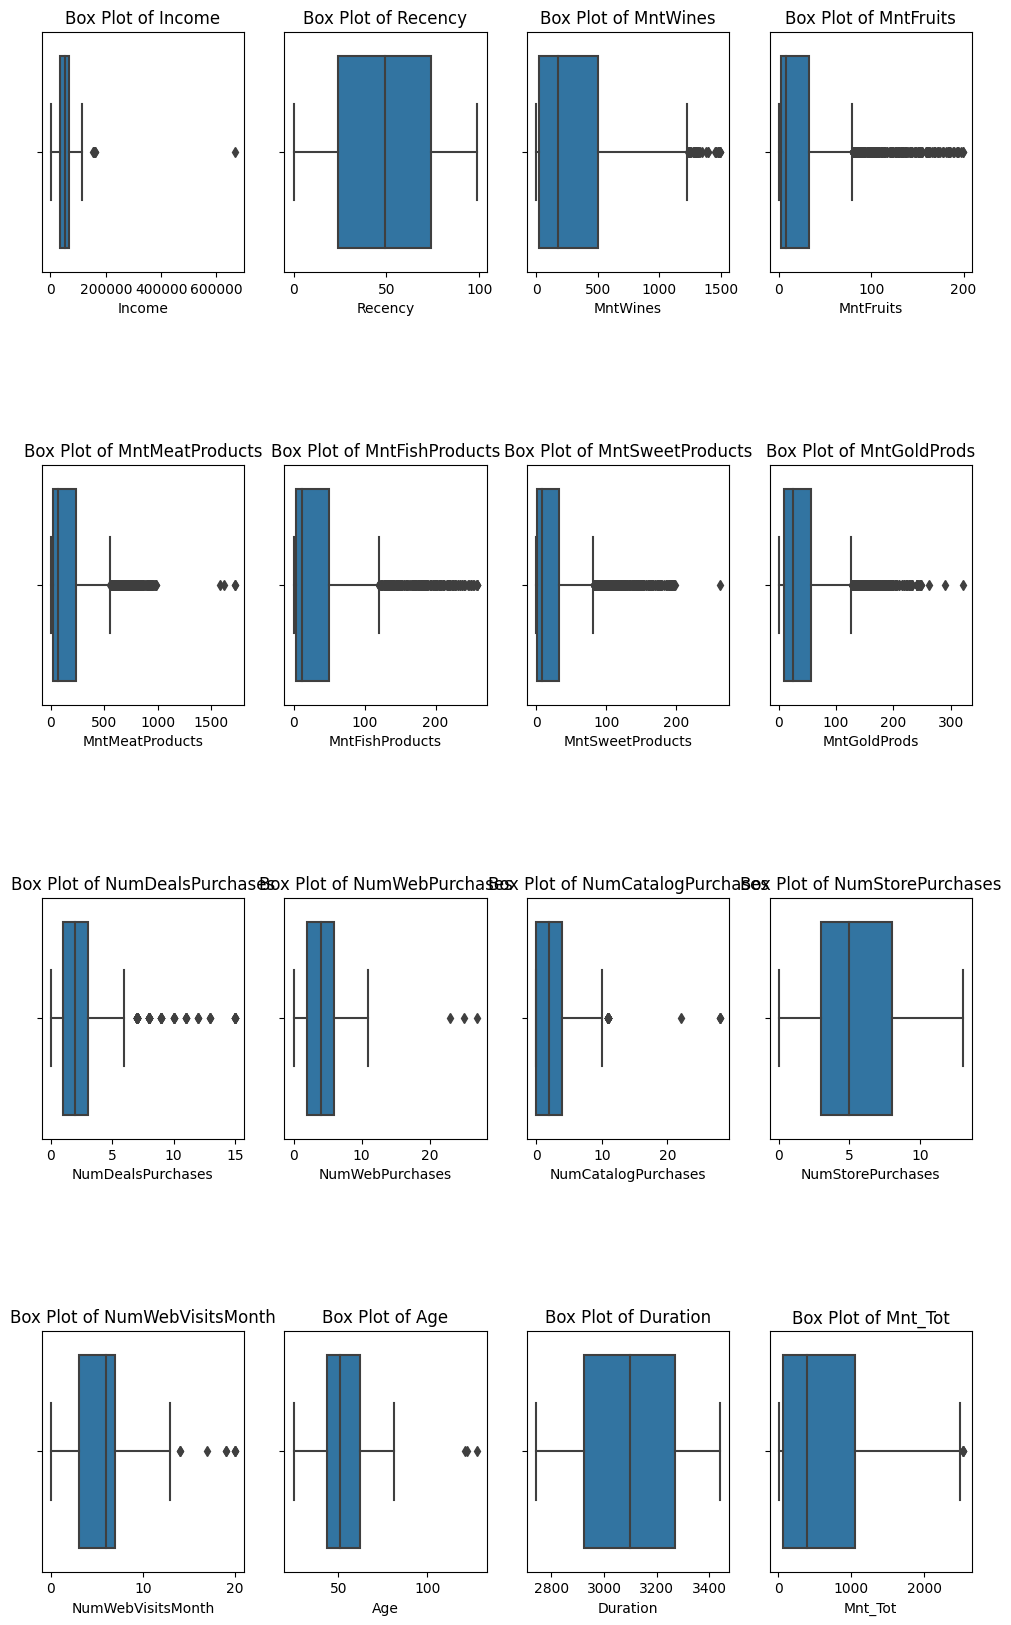

In [19]:
fig, axes=plt.subplots(nrows=4, ncols=4, figsize=(12,20))
axes=axes.flatten()

used_axes = 0

for col in num_col:
    sns.boxplot(data=df, x=col, ax=axes[used_axes])
    axes[used_axes].set_title(f'Box Plot of {col}')
    used_axes += 1
for ax in axes[used_axes:]:
    fig.delaxes(ax)
    
plt.subplots_adjust(hspace=0.8,wspace=0.2)
plt.show()

#### More information on Outliers

In [20]:
def cal_out(data,column):
    Q1 = data[column].quantile(.25)
    Q3 = data[column].quantile(.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f'Total Outliers in {column} are {len(outliers)}, percentage is {round(100 * len(outliers) / len(df[column]),2)}')

In [21]:
for col in num_col:
    cal_out(df,col)

Total Outliers in Income are 8, percentage is 0.36
Total Outliers in Recency are 0, percentage is 0.0
Total Outliers in MntWines are 35, percentage is 1.58
Total Outliers in MntFruits are 246, percentage is 11.1
Total Outliers in MntMeatProducts are 174, percentage is 7.85
Total Outliers in MntFishProducts are 222, percentage is 10.02
Total Outliers in MntSweetProducts are 246, percentage is 11.1
Total Outliers in MntGoldProds are 205, percentage is 9.25
Total Outliers in NumDealsPurchases are 84, percentage is 3.79
Total Outliers in NumWebPurchases are 3, percentage is 0.14
Total Outliers in NumCatalogPurchases are 23, percentage is 1.04
Total Outliers in NumStorePurchases are 0, percentage is 0.0
Total Outliers in NumWebVisitsMonth are 8, percentage is 0.36
Total Outliers in Age are 3, percentage is 0.14
Total Outliers in Duration are 0, percentage is 0.0
Total Outliers in Mnt_Tot are 3, percentage is 0.14


**The outliers in Amount related columns are huge there needs to be some information there, so apart from that we will drop all the other outliers**

#### Removing Outliers

In [22]:
# Making a copy for further changes to be made
df_trans = df.copy(deep=True)

In [23]:
def remove_out(data,column):
    '''Removes outliers by taking dataframe and column name as input and returning new dataframe'''
    Q1 = data[column].quantile(.25)
    Q3 = data[column].quantile(.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data=data[(data[column]>=lower_bound) & (data[column]<=upper_bound)]
    return(data)

In [24]:
for col in num_col:
    if 'Mnt' in col:
        continue
    else:
        df_trans = remove_out(df_trans,col)
print(f'Shape of old {df.shape}, after removal of outliers {df_trans.shape}')

Shape of old (2216, 27), after removal of outliers (2097, 27)


### Pre Processing
***
* Scaling
* Encoding
* PCA Decomposition(Loss of Information)

### Column Transformer using Min Max Scaler and OHE

In [25]:
# Mim Max Scaler and OHE

preprocessor = ColumnTransformer(transformers=[
    ('num',MinMaxScaler(),num_col ),('cat',OneHotEncoder(),cat_col)])

In [26]:
df_trans = preprocessor.fit_transform(df_trans)

# Get feature names
num_features = preprocessor.named_transformers_['num'].get_feature_names_out(num_col)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_col)
features = list(num_features) + list(cat_features)

# Create the DataFrame
df_trans = pd.DataFrame(df_trans, columns=features)

df_trans.head(5)

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Duration,Mnt_Tot,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Kidhome_0,Kidhome_1,Kidhome_2,Teenhome_0,Teenhome_1,Teenhome_2
0,0.527454,0.585859,0.425318,0.446701,0.554878,0.664093,0.444444,0.353414,0.500000,0.727273,1.0,0.307692,0.538462,0.696429,0.948498,0.639253,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.409710,0.383838,0.007368,0.005076,0.006098,0.007722,0.005051,0.024096,0.333333,0.090909,0.1,0.153846,0.384615,0.750000,0.161660,0.007549,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.661981,0.262626,0.285332,0.248731,0.129065,0.428571,0.106061,0.168675,0.166667,0.727273,0.2,0.769231,0.307692,0.553571,0.446352,0.305125,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.213056,0.262626,0.007368,0.020305,0.020325,0.038610,0.015152,0.020080,0.333333,0.181818,0.0,0.307692,0.461538,0.214286,0.198856,0.017878,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.529002,0.949495,0.115874,0.218274,0.119919,0.177606,0.136364,0.060241,0.833333,0.454545,0.3,0.461538,0.384615,0.267857,0.230329,0.164482,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [27]:
df_trans.describe()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Duration,Mnt_Tot,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Kidhome_0,Kidhome_1,Kidhome_2,Teenhome_0,Teenhome_1,Teenhome_2
count,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000,2097.000000
mean,0.461105,0.494728,0.201375,0.133640,0.166007,0.146946,0.137072,0.170532,0.347719,0.363203,0.256843,0.445802,0.404974,0.481376,0.501588,0.234403,0.091559,0.025751,0.502623,0.164044,0.216023,0.000954,0.001431,0.104912,0.386743,0.212685,0.257511,0.034812,0.000954,0.588937,0.391989,0.019075,0.529804,0.449213,0.020982
std,0.206142,0.292998,0.226791,0.200370,0.219203,0.212876,0.206958,0.201045,0.227035,0.235654,0.267573,0.249741,0.175564,0.209698,0.288822,0.240335,0.288472,0.158430,0.500112,0.370404,0.411628,0.030875,0.037805,0.306513,0.487120,0.409304,0.437367,0.183346,0.030875,0.492144,0.488311,0.136821,0.499230,0.497533,0.143359
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.293742,0.242424,0.015405,0.005076,0.015244,0.011583,0.005051,0.036145,0.166667,0.181818,0.000000,0.230769,0.230769,0.321429,0.253219,0.023441,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.453447,0.494949,0.111855,0.040609,0.065041,0.046332,0.040404,0.096386,0.333333,0.272727,0.200000,0.384615,0.461538,0.464286,0.497854,0.139054,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.630773,0.747475,0.338245,0.167513,0.235772,0.193050,0.171717,0.216867,0.500000,0.545455,0.400000,0.615385,0.538462,0.642857,0.755365,0.410012,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


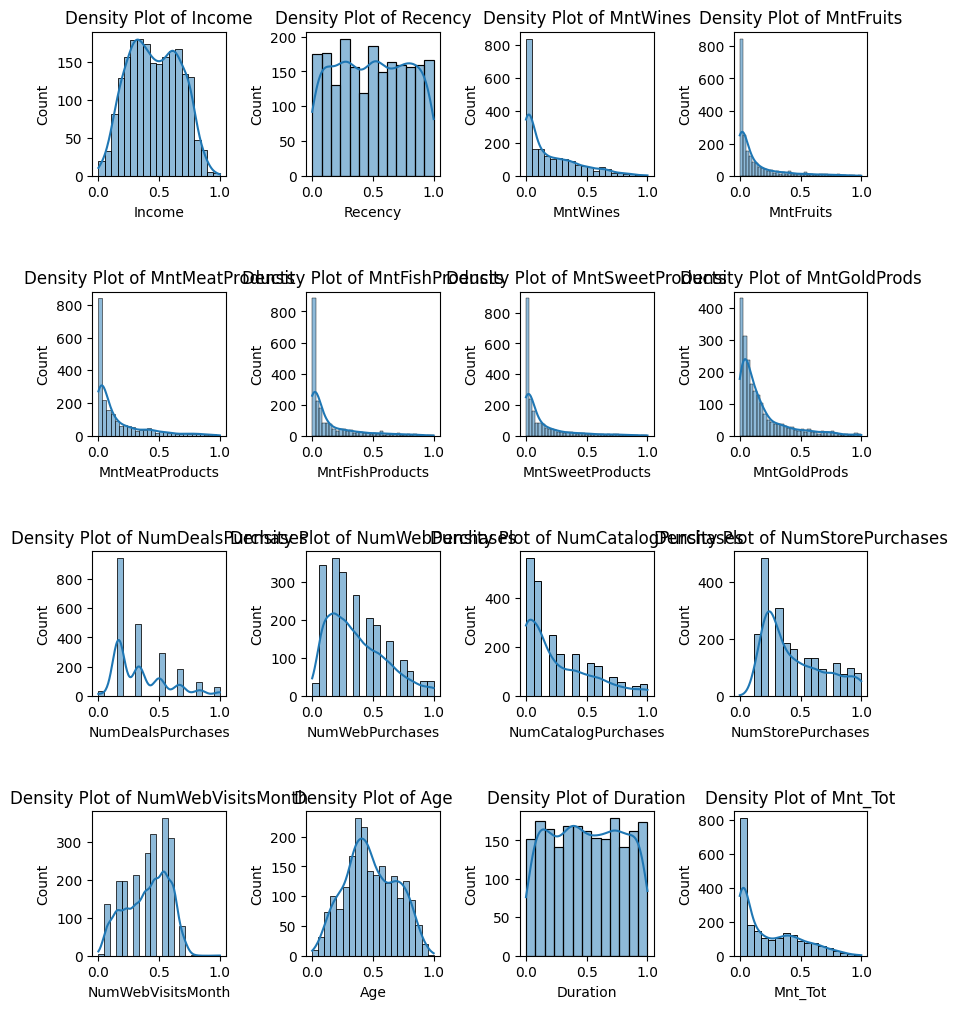

In [28]:
fig, axes=plt.subplots(nrows=4, ncols=4, figsize=(10,12))
axes=axes.flatten()

used_axes = 0
for ind,col in enumerate(num_col):
    sns.histplot(data=df_trans,x=col,ax=axes[used_axes],kde=True)
    axes[used_axes].set_title(f'Density Plot of {col}')
    used_axes+=1

for ax in axes[used_axes:]:
    fig.delaxes(ax)
    
plt.subplots_adjust(hspace=0.8,wspace=0.6)
plt.show()

### To Do
***
* We saw for transformed plots of MinMax and the Standard Scaler but both are almost same in the shape other than the x-axis range
* We will perform PCA for the data and reduce it to 3 dimnensions- 
    * easy to visualize and interpret
    * check loss of information occured
* We will first remove outliers from all the numerical columns
    * Use IQR or Z score for this 
***

### PCA Decompotision for Dimensionality Reduction

In [29]:
from sklearn.decomposition import PCA

In [30]:
pca_decom = PCA(n_components=3,random_state=14)
df_trans_pca = pca_decom.fit_transform(df_trans)
df_trans_pca

array([[ 1.01724828, -0.88946274, -0.53910483],
       [-0.96245193,  0.63835089, -0.6280631 ],
       [ 0.66898147, -0.64589423, -0.49752026],
       ...,
       [ 0.64829832, -0.69829396, -0.4689215 ],
       [ 0.78082083,  0.78765118,  0.44098011],
       [-0.81741288,  0.91801898,  0.6452444 ]])

### Clustering

To Do
* Elbow Method
* Silhottes Score
* K Means
* DBSCAN

In [31]:
# Function to calculate the WCSS (within-cluster sum of squares)
def calculate_wcss(data):
    wcss = []
    for n in range(1, 11):
        kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=14)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

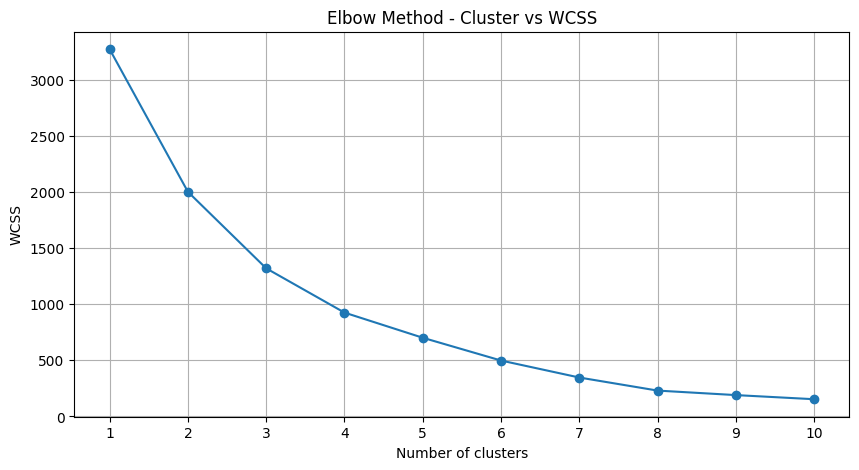

In [32]:
# Calculate WCSS for different number of clusters
wcss = calculate_wcss(df_trans_pca)

# Plot the results to visualize the Elbow method
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method - Cluster vs WCSS')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

According to Elbow method we can take 4 as number of clusters

In [33]:
import plotly.express as px

In [34]:
kmeans_4 = KMeans(n_init="auto", n_clusters=4, random_state=42, init='k-means++')

kmeans_4.fit(df_trans_pca)

labels_4 = kmeans_4.labels_

df_trans['Cluster_4_KM'] = labels_4

#3D plot for 4 clusters

fig = px.scatter_3d(df_trans_pca, x=df_trans_pca[:, 0], y=df_trans_pca[:, 1], z=df_trans_pca[:, 2], color=labels_4)

fig.update_layout(title='3D Plot with 4 Clusters', scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'))

fig.update_traces(marker=dict(size=4))

fig.show()

### Check Silhottes Score

In [35]:
# Defining X to be used further

X = df_trans_pca

For n_clusters = 3 The average silhouette_score is : 0.433494211362637
For n_clusters = 4 The average silhouette_score is : 0.4882958832741791
For n_clusters = 5 The average silhouette_score is : 0.5293269347150587
For n_clusters = 6 The average silhouette_score is : 0.5822516804827352


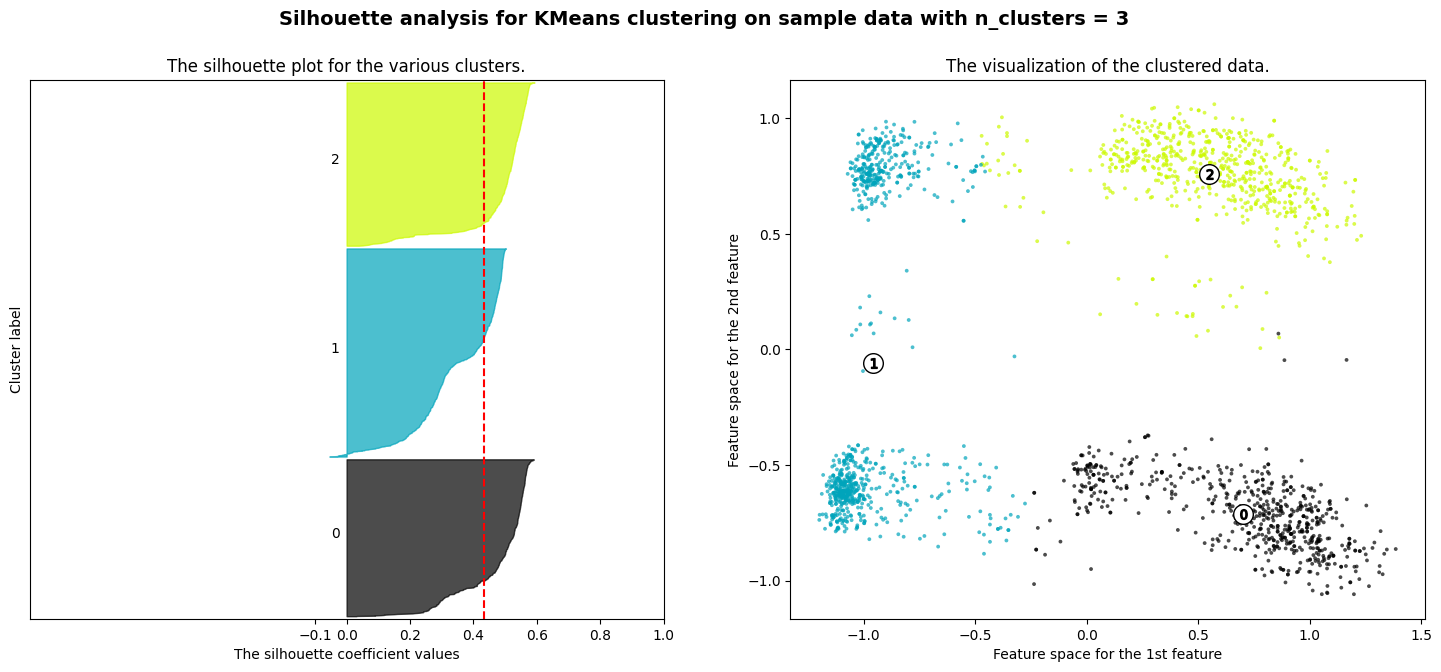

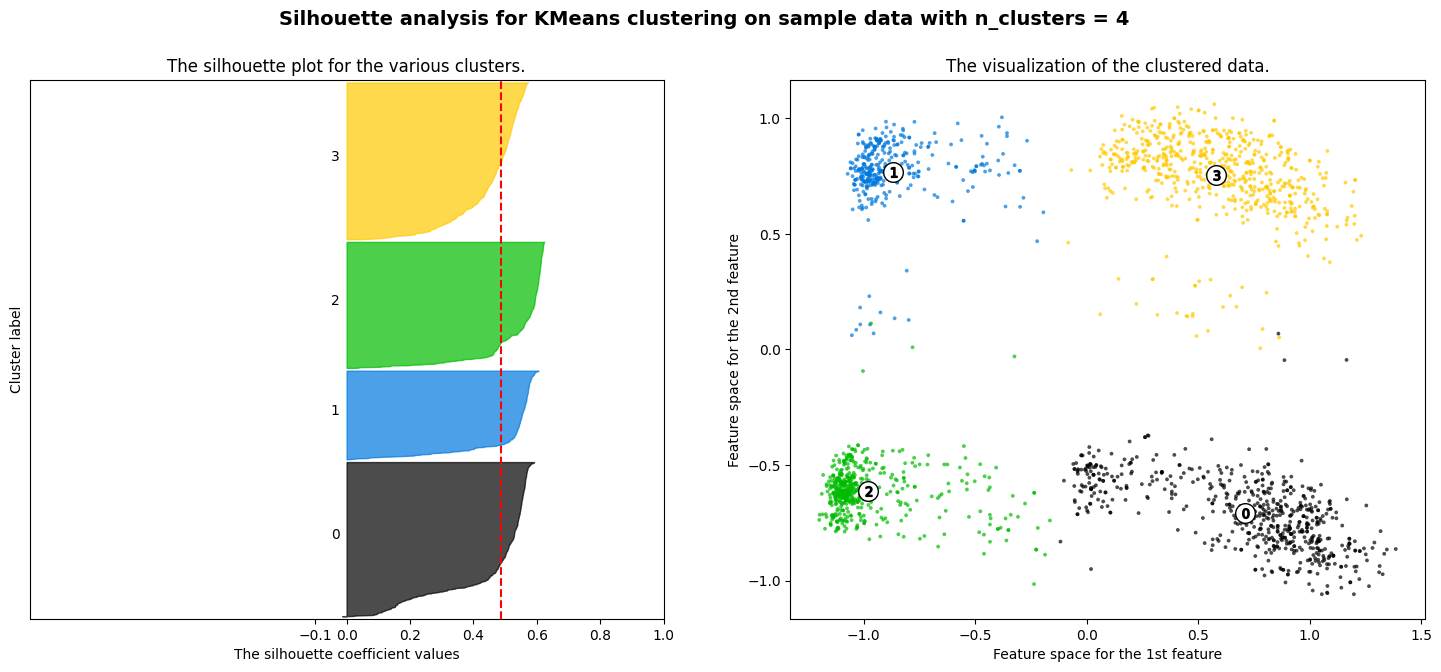

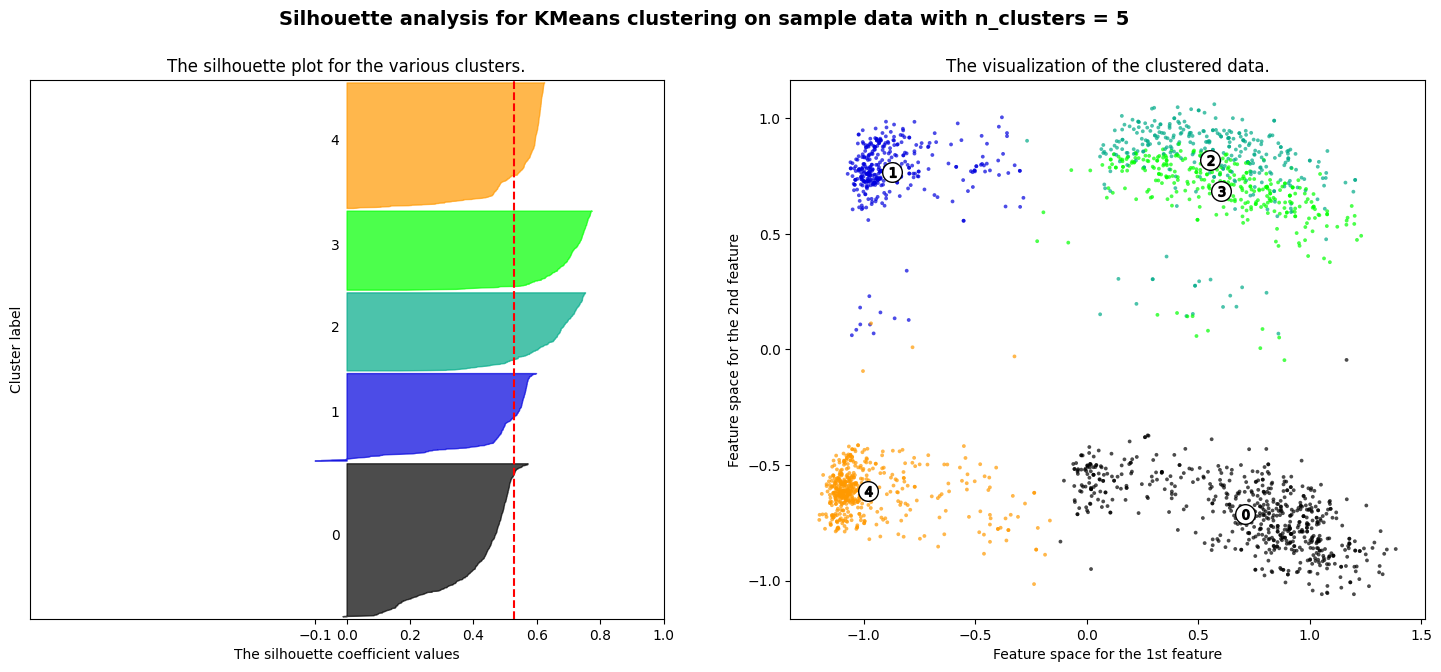

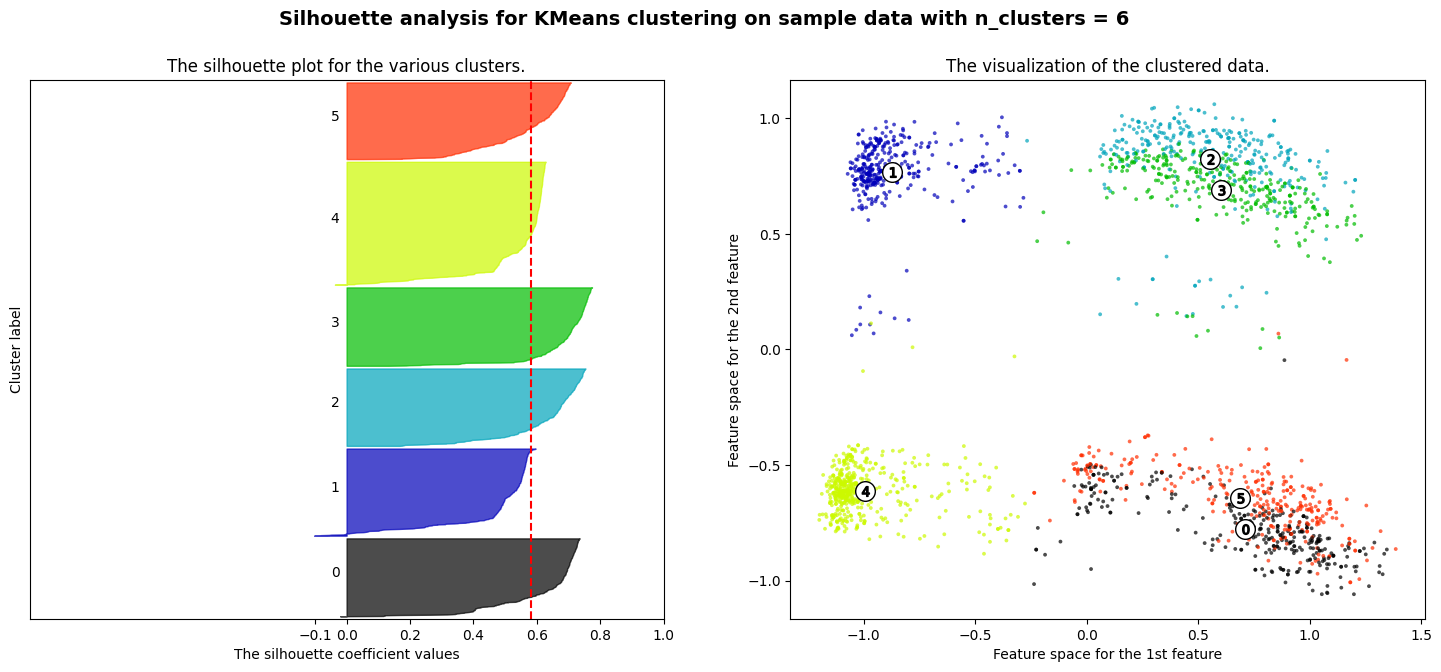

In [36]:
range_n_clusters = [3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=14)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

## Understanding Silhouette score
***
* The silhouette score is a metric used to evaluate the quality of clustering in a dataset. It measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
* A good score will be close to 1 and poor one will be close to -1
    * Score = 1: Indicates that the sample is far away from the neighboring clusters and very close to the cluster it is assigned to. This is the ideal situation.
    * Score = 0: Indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
    * Negative values: Indicate that the sample might have been assigned to the wrong cluster, as it is closer to a neighboring cluster than to the cluster it is assigned to.
 ***

In [37]:
df_trans['Cluster_4_KM'].value_counts()

Cluster_4_KM
3    625
1    615
2    503
0    354
Name: count, dtype: int64

### DBSCAN Clustering

#### Finding Value of Epsilon for DBSCAN

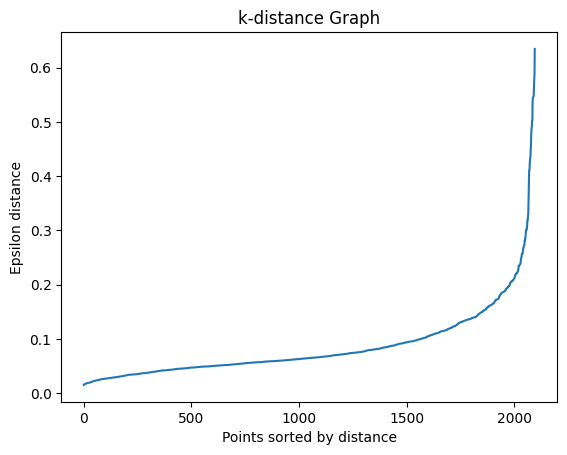

In [38]:
# Assuming X is your dataset
min_samples = 10

neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# Sort distances to the k-th nearest neighbor in ascending order
distances = np.sort(distances[:, min_samples-1], axis=0)

# Plot the distances
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('Epsilon distance')
plt.title('k-distance Graph')
plt.show()

* Taking 10 as min_samples and looking for epsilon value
* Find elbow point(sudden change) and epsilon value for that point
* We will use hit and trial to calculate the min_samples value in the next step

The average silhouette_score is : 0.6462398473217411


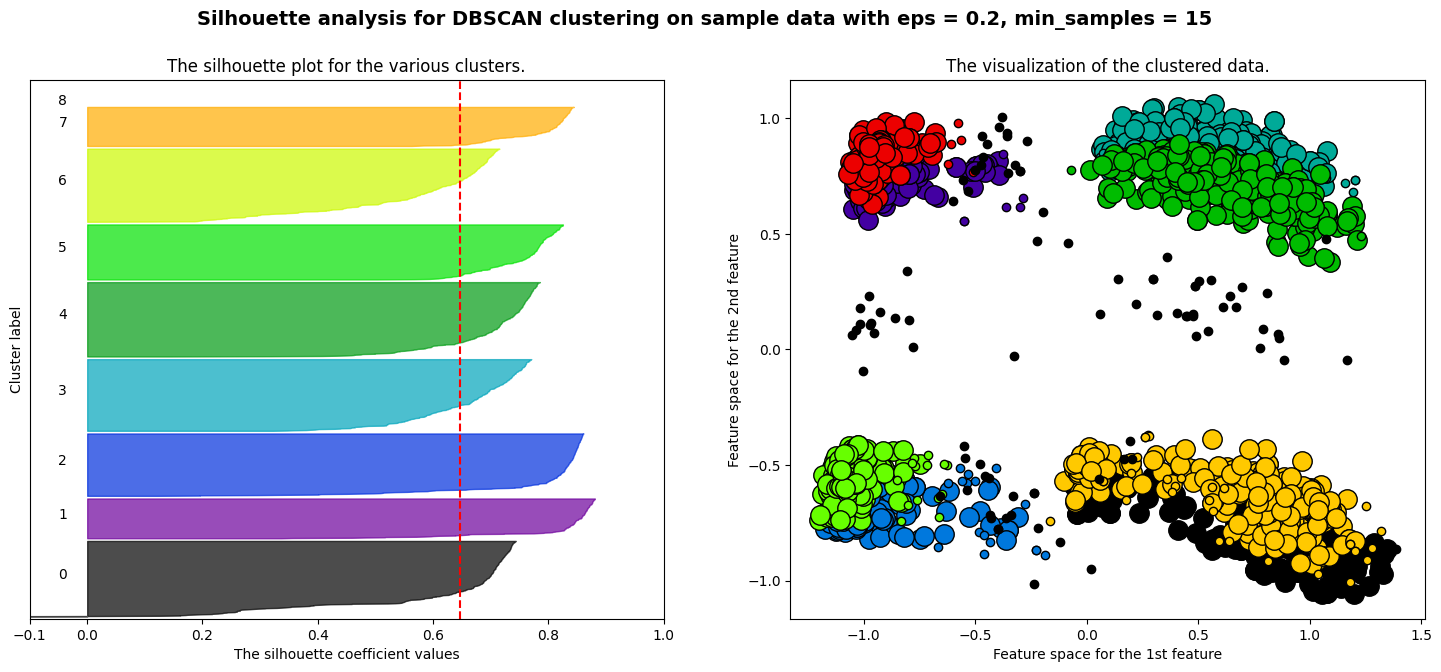

In [39]:
# Set parameters for DBSCAN
# Selected from K-Distance Plot
eps = .2
# Selected from hit and trial from min_samples in range of [5-30]
min_samples = 15

# Initialize the DBSCAN clusterer and train the model
clusterer = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = clusterer.fit_predict(X)

# The silhouette_score gives the average value for all the samples
# Note: Silhouette score only makes sense if there are at least 2 clusters
if len(set(cluster_labels)) > 1:
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"The average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters
    ax1.set_ylim([0, len(X) + (len(set(cluster_labels)) + 1) * 10])

    y_lower = 10
    for i in range(len(set(cluster_labels))):
        if i == -1:
            continue  # Skip noise points

        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / len(set(cluster_labels)))
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / len(set(cluster_labels)))
    ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    # Labeling the clusters
    core_samples_mask = np.zeros_like(cluster_labels, dtype=bool)
    core_samples_mask[clusterer.core_sample_indices_] = True

    # Black removed and is used for noise instead.
    unique_labels = set(cluster_labels)
    for k, col in zip(unique_labels, cm.nipy_spectral(np.linspace(0, 1, len(unique_labels)))):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (cluster_labels == k)

        xy = X[class_member_mask & core_samples_mask]
        ax2.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        ax2.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(f"Silhouette analysis for DBSCAN clustering on sample data with eps = {eps}, min_samples = {min_samples}",
                 fontsize=14, fontweight="bold")

    plt.show()
else:
    print("The silhouette score cannot be calculated for a single cluster.")

* min_sample = 15 gave the largest silhottes score

In [40]:
fig = px.scatter_3d(df_trans_pca, x=df_trans_pca[:, 0], y=df_trans_pca[:, 1], z=df_trans_pca[:, 2], color=cluster_labels)

fig.update_layout(title='3D Plot with 9 Clusters for DBSCAN', scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'))

fig.update_traces(marker=dict(size=4))

fig.show()

In [41]:
df_trans['Cluster_DB_9'] = cluster_labels
df_trans.head()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Duration,Mnt_Tot,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Kidhome_0,Kidhome_1,Kidhome_2,Teenhome_0,Teenhome_1,Teenhome_2,Cluster_4_KM,Cluster_DB_9
0,0.527454,0.585859,0.425318,0.446701,0.554878,0.664093,0.444444,0.353414,0.500000,0.727273,1.0,0.307692,0.538462,0.696429,0.948498,0.639253,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0
1,0.409710,0.383838,0.007368,0.005076,0.006098,0.007722,0.005051,0.024096,0.333333,0.090909,0.1,0.153846,0.384615,0.750000,0.161660,0.007549,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
2,0.661981,0.262626,0.285332,0.248731,0.129065,0.428571,0.106061,0.168675,0.166667,0.727273,0.2,0.769231,0.307692,0.553571,0.446352,0.305125,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0
3,0.213056,0.262626,0.007368,0.020305,0.020325,0.038610,0.015152,0.020080,0.333333,0.181818,0.0,0.307692,0.461538,0.214286,0.198856,0.017878,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2,2
4,0.529002,0.949495,0.115874,0.218274,0.119919,0.177606,0.136364,0.060241,0.833333,0.454545,0.3,0.461538,0.384615,0.267857,0.230329,0.164482,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2,5


In [42]:
df_trans['Cluster_DB_9'].value_counts()

Cluster_DB_9
 0    308
 4    304
 6    299
 3    293
 2    255
 5    225
 1    163
 7    160
-1     90
Name: count, dtype: int64

## To Do Further
***
* Train a RF on this clustered data without scaling and check the prediction and how good it can fit
* Find loss of information for PCA done
***